## 1. Setup & Import Libraries

In [43]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")

Project root: c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]


In [44]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Print versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 1.24.3
Pandas version: 2.0.3


In [45]:
# Import our semi-supervised module
from src.models.semi_supervised import (
    # Split functions
    create_labeled_unlabeled_split,
    create_multiple_splits,
    
    # Training functions
    train_self_training,
    train_self_training_rf,
    train_label_propagation,
    train_label_spreading,
    
    # Analysis
    analyze_pseudo_labels,
    evaluate_semi_supervised,
    
    # Comparison
    compare_semi_supervised_methods,
    run_label_fraction_experiment,
    
    # Visualization
    plot_learning_curve_by_labels,
    plot_pseudo_label_confusion_matrix
)

print("✅ Semi-supervised module imported successfully!")

✅ Semi-supervised module imported successfully!


## 2. Load Data

In [46]:
# Load processed data
data_dir = os.path.join(project_root, 'data', 'processed')

# Training data (with SMOTE resampling from Phase 4)
X_train = pd.read_csv(os.path.join(data_dir, 'X_train_resampled.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train_resampled.csv')).squeeze()

# Test data
X_test = pd.read_csv(os.path.join(data_dir, 'X_test_encoded.csv'))
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).squeeze()

print(f"📊 Data Loaded:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape:  {X_test.shape}")
print(f"   y_test shape:  {y_test.shape}")
print(f"\n   Train class distribution:")
print(f"   {y_train.value_counts().to_dict()}")

📊 Data Loaded:
   X_train shape: (120266, 40)
   y_train shape: (120266,)
   X_test shape:  (23878, 286)
   y_test shape:  (23878,)

   Train class distribution:
   {0: 60133, 1: 60133}


In [47]:
# Ensure columns match between train and test
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

if train_cols != test_cols:
    # Find common columns
    common_cols = list(train_cols.intersection(test_cols))
    print(f"⚠️ Column mismatch! Using {len(common_cols)} common columns.")
    
    # Show differences
    only_train = train_cols - test_cols
    only_test = test_cols - train_cols
    if only_train:
        print(f"   Only in train: {only_train}")
    if only_test:
        print(f"   Only in test: {only_test}")
    
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
else:
    print("✅ Columns match between train and test")

⚠️ Column mismatch! Using 40 common columns.
   Only in test: {'country_MYT', 'country_CUB', 'country_URY', 'country_SVK', 'reserved_room_type_C', 'assigned_room_type_B', 'arrival_date_month_July', 'country_ZMB', 'country_BEN', 'country_ETH', 'country_DJI', 'country_ITA', 'arrival_date_month_August', 'country_TJK', 'adr_category_Luxury', 'lead_time_category_180-365days', 'country_CHL', 'country_HUN', 'country_ISR', 'country_OMN', 'country_PLW', 'country_ZWE', 'market_segment_Online TA', 'assigned_room_type_G', 'country_SRB', 'country_HND', 'country_NCL', 'country_UMI', 'country_MMR', 'country_SYR', 'country_MRT', 'reserved_room_type_E', 'country_BRB', 'country_GBR', 'country_LBN', 'country_TGO', 'country_ATA', 'country_UKR', 'meal_FB', 'country_BHR', 'country_ESP', 'country_BRA', 'country_NOR', 'country_grouped_IRL', 'assigned_room_type_L', 'country_IND', 'country_KWT', 'arrival_date', 'country_GGY', 'country_KNA', 'distribution_channel_TA/TO', 'country_CIV', 'country_GEO', 'country_PE

In [48]:
# For semi-supervised experiments, use smaller subset for efficiency
# (Label Propagation/Spreading can be slow on very large datasets)

SAMPLE_SIZE = 20000  # Use subset for faster experiments

if len(X_train) > SAMPLE_SIZE:
    print(f"📉 Sampling {SAMPLE_SIZE:,} samples from {len(X_train):,} for faster experiments...")
    
    # Stratified sampling
    from sklearn.model_selection import train_test_split
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train,
        train_size=SAMPLE_SIZE,
        stratify=y_train,
        random_state=42
    )
    
    print(f"   Sampled X_train: {X_train_sample.shape}")
    print(f"   Sampled y_train: {y_train_sample.shape}")
    print(f"   Class distribution: {y_train_sample.value_counts().to_dict()}")
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print(f"✅ Using full training data: {len(X_train):,} samples")

📉 Sampling 20,000 samples from 120,266 for faster experiments...
   Sampled X_train: (20000, 40)
   Sampled y_train: (20000,)
   Class distribution: {0: 10000, 1: 10000}


## 3. Create Labeled/Unlabeled Splits

Giả lập tình huống chỉ có một phần nhỏ dữ liệu được gán nhãn.

In [49]:
# Create splits with different labeled fractions
label_fractions = [0.05, 0.10, 0.20]

splits = create_multiple_splits(
    X_train_sample, y_train_sample,
    fractions=label_fractions,
    random_state=42,
    verbose=True
)

CREATING MULTIPLE SPLITS
   5% labeled: 1,000 samples
   10% labeled: 2,000 samples
   20% labeled: 4,000 samples


In [50]:
# Detailed view of 10% split
X, y_semi_10, mask_10 = splits[0.10]

print("\n📊 Detailed 10% Split:")
print(f"   Total samples: {len(y_semi_10):,}")
print(f"   Labeled (y != -1): {(y_semi_10 != -1).sum():,}")
print(f"   Unlabeled (y == -1): {(y_semi_10 == -1).sum():,}")
print(f"\n   First 20 labels: {y_semi_10[:20]}")


📊 Detailed 10% Split:
   Total samples: 20,000
   Labeled (y != -1): 2,000
   Unlabeled (y == -1): 18,000

   First 20 labels: [ 0. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1.
 -1. -1.]


## 4. Self-Training

Self-Training hoạt động:
1. Huấn luyện model trên dữ liệu đã gán nhãn
2. Dự đoán trên dữ liệu chưa gán nhãn
3. Thêm các dự đoán có độ tin cậy cao (>= threshold) vào tập labeled
4. Lặp lại cho đến khi hội tụ

In [51]:
# Train Self-Training with 10% labeled data
X_10, y_semi_10, mask_10 = splits[0.10]

print("="*70)
print("SELF-TRAINING WITH LOGISTIC REGRESSION (threshold=0.9)")
print("="*70)

model_st_lr, info_st_lr = train_self_training(
    X_10, y_semi_10,
    threshold=0.9,
    verbose=True
)

SELF-TRAINING WITH LOGISTIC REGRESSION (threshold=0.9)
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 2,000
Initial unlabeled: 18,000
End of iteration 1, added 5899 new labels.
End of iteration 2, added 1865 new labels.
End of iteration 3, added 1686 new labels.
End of iteration 4, added 1075 new labels.
End of iteration 5, added 296 new labels.
End of iteration 6, added 553 new labels.
End of iteration 7, added 152 new labels.
End of iteration 8, added 180 new labels.
End of iteration 9, added 132 new labels.
End of iteration 10, added 22 new labels.

📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 11,860
   Final labeled: 13,860 (69.3%)


In [52]:
# Evaluate Self-Training model on test set
metrics_st_lr = evaluate_semi_supervised(
    model_st_lr, X_test, y_test,
    model_name="Self-Training (LR, threshold=0.9)",
    verbose=True
)


📊 Self-Training (LR, threshold=0.9) Evaluation:
   Accuracy:  0.7421
   Precision: 0.6371
   Recall:    0.7056
   F1 Score:  0.6696
   ROC-AUC:   0.8114
   PR-AUC:    0.7649


In [53]:
# Self-Training with higher threshold (more conservative)
print("\n" + "="*70)
print("SELF-TRAINING WITH HIGHER THRESHOLD (0.95)")
print("="*70)

model_st_95, info_st_95 = train_self_training(
    X_10, y_semi_10,
    threshold=0.95,
    verbose=True
)

metrics_st_95 = evaluate_semi_supervised(
    model_st_95, X_test, y_test,
    model_name="Self-Training (threshold=0.95)",
    verbose=True
)


SELF-TRAINING WITH HIGHER THRESHOLD (0.95)
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.95
Max iterations: 10
Initial labeled: 2,000
Initial unlabeled: 18,000
End of iteration 1, added 4055 new labels.
End of iteration 2, added 1919 new labels.
End of iteration 3, added 719 new labels.
End of iteration 4, added 166 new labels.
End of iteration 5, added 99 new labels.
End of iteration 6, added 102 new labels.
End of iteration 7, added 70 new labels.
End of iteration 8, added 334 new labels.
End of iteration 9, added 93 new labels.
End of iteration 10, added 168 new labels.

📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 7,725
   Final labeled: 9,725 (48.6%)

📊 Self-Training (threshold=0.95) Evaluation:
   Accuracy:  0.7530
   Precision: 0.6515
   Recall:    0.7160
   F1 Score:  0.6823
   ROC-AUC:   0.8276
   PR-AUC:    0.7897


In [54]:
# Compare thresholds
print("\n📊 Self-Training Threshold Comparison (10% labeled):")
print(f"   Threshold 0.90: F1={metrics_st_lr['f1']:.4f}, Pseudo-labels={info_st_lr['n_pseudo_labeled']:,}")
print(f"   Threshold 0.95: F1={metrics_st_95['f1']:.4f}, Pseudo-labels={info_st_95['n_pseudo_labeled']:,}")


📊 Self-Training Threshold Comparison (10% labeled):
   Threshold 0.90: F1=0.6696, Pseudo-labels=11,860
   Threshold 0.95: F1=0.6823, Pseudo-labels=7,725


## 5. Pseudo-Label Analysis

Phân tích chất lượng của pseudo-labels so với ground truth.

In [55]:
# Analyze pseudo-label quality for Self-Training
# Get the transduced labels (after self-training)
y_pseudo_st = model_st_lr.transduction_

# Mask for originally unlabeled samples
mask_unlabeled = ~mask_10

# Analyze
pseudo_analysis = analyze_pseudo_labels(
    y_true=y_train_sample.values,
    y_pseudo=y_pseudo_st,
    mask_unlabeled=mask_unlabeled,
    X=X_train_sample,
    feature_to_analyze='lead_time' if 'lead_time' in X_train_sample.columns else None,
    verbose=True
)


PSEUDO-LABEL ANALYSIS

📊 Pseudo-Label Quality:
   Originally unlabeled: 18,000
   Pseudo-labeled: 11,860
   Still unlabeled: 6,140

   Accuracy:  0.8464
   Precision: 0.8679
   Recall:    0.8304
   F1 Score:  0.8487

❌ Errors (on pseudo-labeled samples):
   Total errors: 1,822 (15.36%)
   False Positives: 778 (predicted cancel, actually not)
   False Negatives: 1,044 (predicted not cancel, actually cancel)

📋 Confusion Matrix:
   TN=4,928  FP=778
   FN=1,044  TP=5,110

📈 Error Rate by lead_time:
   Q1: 12.58% (373/2965 errors)
   Q2: 17.72% (526/2968 errors)
   Q3: 17.36% (516/2973 errors)
   Q4: 13.78% (407/2954 errors)


✅ Saved confusion matrix to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\pseudo_label_cm_self_training.png


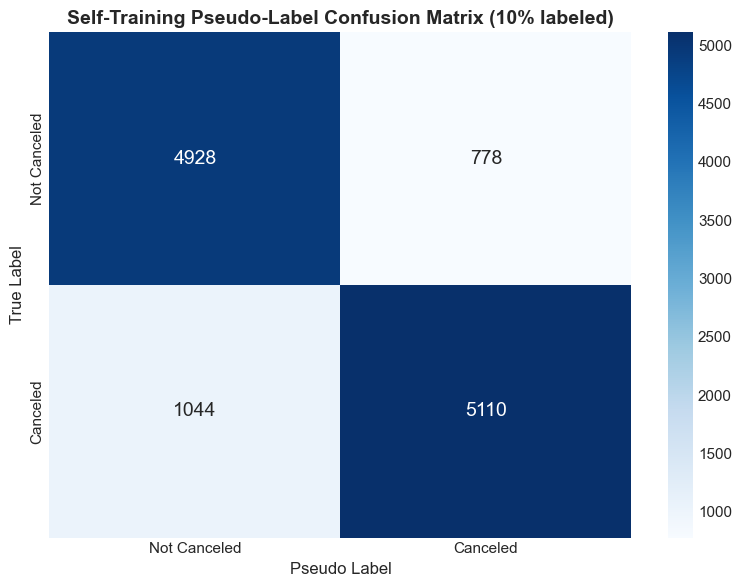

In [56]:
# Plot pseudo-label confusion matrix
fig = plot_pseudo_label_confusion_matrix(
    y_true=y_train_sample.values,
    y_pseudo=y_pseudo_st,
    mask_unlabeled=mask_unlabeled,
    title='Self-Training Pseudo-Label Confusion Matrix (10% labeled)',
    save_path=os.path.join(project_root, 'outputs', 'figures', 'pseudo_label_cm_self_training.png'),
    show=True
)

## 6. Label Propagation & Spreading

Các phương pháp graph-based semi-supervised learning.

In [57]:
# Use smaller sample for Label Propagation (memory intensive)
LABEL_PROP_SAMPLE = min(10000, len(X_train_sample))

if len(X_train_sample) > LABEL_PROP_SAMPLE:
    from sklearn.model_selection import train_test_split
    X_lp, _, y_lp, _ = train_test_split(
        X_train_sample, y_train_sample,
        train_size=LABEL_PROP_SAMPLE,
        stratify=y_train_sample,
        random_state=42
    )
    print(f"📉 Using {LABEL_PROP_SAMPLE:,} samples for Label Propagation")
else:
    X_lp = X_train_sample
    y_lp = y_train_sample

# Create 10% split for label propagation
X_lp, y_semi_lp, mask_lp = create_labeled_unlabeled_split(
    X_lp, y_lp,
    labeled_fraction=0.10,
    random_state=42,
    verbose=True
)

📉 Using 10,000 samples for Label Propagation
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 10.0%
Target labeled samples: 1,000

📊 Split Result:
   Labeled samples: 1,000 (10.0%)
   Unlabeled samples: 9,000 (90.0%)

   Labeled class distribution:
      Class 0: 500 (50.0%)
      Class 1: 500 (50.0%)


In [58]:
# Train Label Propagation with KNN kernel
print("\n" + "="*70)
print("LABEL PROPAGATION (KNN kernel)")
print("="*70)

model_lp, info_lp = train_label_propagation(
    X_lp, y_semi_lp,
    kernel='knn',
    n_neighbors=7,
    verbose=True
)

# Evaluate
metrics_lp = evaluate_semi_supervised(
    model_lp, X_test, y_test,
    model_name="Label Propagation (KNN)",
    verbose=True
)


LABEL PROPAGATION (KNN kernel)
TRAINING LABEL PROPAGATION
Kernel: knn
N neighbors: 7
Labeled samples: 1,000
Unlabeled samples: 9,000

📊 Label Propagation Results:
   Iterations: 1000

📊 Label Propagation (KNN) Evaluation:
   Accuracy:  0.5651
   Precision: 0.4375
   Recall:    0.6097
   F1 Score:  0.5095


In [59]:
# Train Label Spreading
print("\n" + "="*70)
print("LABEL SPREADING (KNN kernel, alpha=0.2)")
print("="*70)

model_ls, info_ls = train_label_spreading(
    X_lp, y_semi_lp,
    kernel='knn',
    n_neighbors=7,
    alpha=0.2,
    verbose=True
)

# Evaluate
metrics_ls = evaluate_semi_supervised(
    model_ls, X_test, y_test,
    model_name="Label Spreading (KNN, alpha=0.2)",
    verbose=True
)


LABEL SPREADING (KNN kernel, alpha=0.2)
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 1,000
Unlabeled samples: 9,000

📊 Label Spreading Results:
   Iterations: 8

📊 Label Spreading (KNN, alpha=0.2) Evaluation:
   Accuracy:  0.5745
   Precision: 0.4428
   Recall:    0.5756
   F1 Score:  0.5006


## 7. Comparison: Supervised vs Semi-Supervised

In [60]:
# Compare methods at 10% labeled
print("\n" + "#"*70)
print("# COMPARISON: SUPERVISED vs SEMI-SUPERVISED (10% labeled)")
print("#"*70)

comparison_10 = compare_semi_supervised_methods(
    X_lp, y_lp, X_test, y_test,
    labeled_fraction=0.10,
    methods=['supervised', 'self_training', 'label_spreading'],
    random_state=42,
    verbose=True
)


######################################################################
# COMPARISON: SUPERVISED vs SEMI-SUPERVISED (10% labeled)
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 10.0%
Target labeled samples: 1,000

📊 Split Result:
   Labeled samples: 1,000 (10.0%)
   Unlabeled samples: 9,000 (90.0%)

   Labeled class distribution:
      Class 0: 500 (50.0%)
      Class 1: 500 (50.0%)

Training: SUPERVISED

📊 supervised Evaluation:
   Accuracy:  0.7477
   Precision: 0.6398
   Recall:    0.7296
   F1 Score:  0.6817
   ROC-AUC:   0.8323
   PR-AUC:    0.7956

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 1,000
Initial unlabeled: 9,000
End of iteration 1, added 3275 new labels.
End of iteration 2, added 778 new labels.
End of iteration 3, added 446 new labels.
End of iteration 4, added 201 new labels.
End of iteration 5, ad

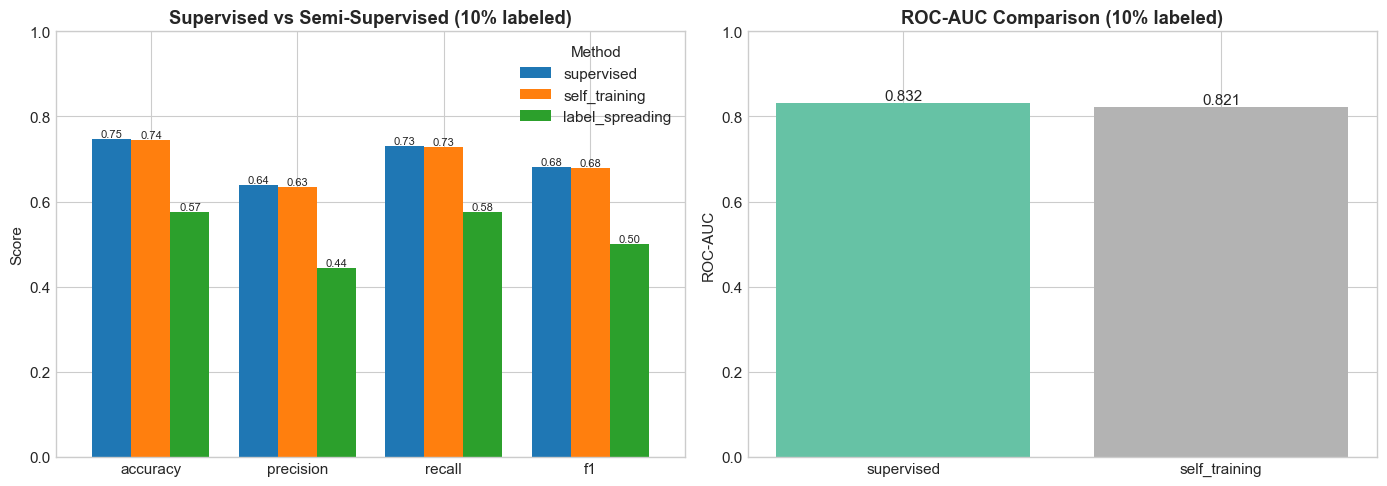


✅ Figure saved to outputs/figures/semi_supervised_comparison.png


In [61]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
comparison_plot = comparison_10[metrics_to_plot].T

comparison_plot.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
axes[0].set_title('Supervised vs Semi-Supervised (10% labeled)', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(title='Method')
axes[0].set_ylim(0, 1)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=8)

# ROC-AUC if available
if 'roc_auc' in comparison_10.columns:
    roc_data = comparison_10['roc_auc'].dropna()
    colors = plt.cm.Set2(np.linspace(0, 1, len(roc_data)))
    bars = axes[1].bar(roc_data.index, roc_data.values, color=colors)
    axes[1].set_title('ROC-AUC Comparison (10% labeled)', fontweight='bold')
    axes[1].set_ylabel('ROC-AUC')
    axes[1].set_ylim(0, 1)
    axes[1].bar_label(bars, fmt='%.3f')
else:
    axes[1].text(0.5, 0.5, 'ROC-AUC not available', ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'outputs', 'figures', 'semi_supervised_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to outputs/figures/semi_supervised_comparison.png")

## 8. Label Fraction Experiment (5%, 10%, 20%)

In [62]:
# Run experiments across different label fractions
print("\n" + "#"*70)
print("# LABEL FRACTION EXPERIMENT")
print("#"*70)

# Use smaller data for efficiency
experiment_results = run_label_fraction_experiment(
    X_lp, y_lp, X_test, y_test,
    fractions=[0.05, 0.10, 0.20],
    random_state=42,
    verbose=True
)


######################################################################
# LABEL FRACTION EXPERIMENT
######################################################################

######################################################################
# EXPERIMENT: 5% LABELED DATA
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 5.0%
Target labeled samples: 500

📊 Split Result:
   Labeled samples: 500 (5.0%)
   Unlabeled samples: 9,500 (95.0%)

   Labeled class distribution:
      Class 0: 250 (50.0%)
      Class 1: 250 (50.0%)

Training: SUPERVISED

📊 supervised Evaluation:
   Accuracy:  0.7552
   Precision: 0.6615
   Recall:    0.6946
   F1 Score:  0.6777
   ROC-AUC:   0.8274
   PR-AUC:    0.7884

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 500
Initial unlabeled: 9,500
End of iteration 1, added 2884 new labels.
End of iterat

✅ Saved learning curve to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\semi_supervised_learning_curve.png


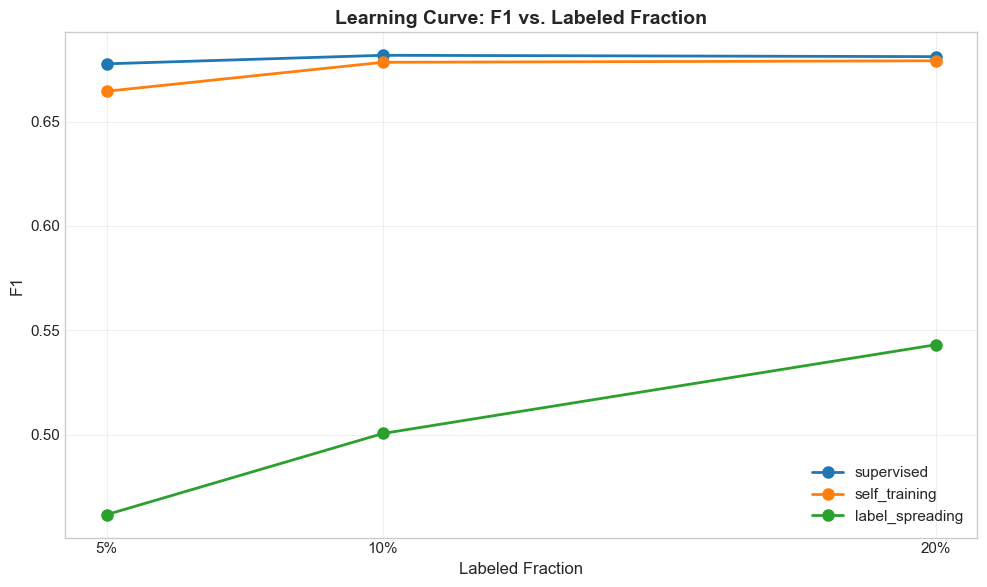

In [63]:
# Plot learning curve
fig = plot_learning_curve_by_labels(
    experiment_results,
    metric='f1',
    figsize=(10, 6),
    save_path=os.path.join(project_root, 'outputs', 'figures', 'semi_supervised_learning_curve.png'),
    show=True
)

In [64]:
# Summary table
print("\n" + "="*70)
print("SUMMARY: F1 SCORES BY LABELED FRACTION")
print("="*70)

summary_data = {}
for frac, results in experiment_results.items():
    if 'f1' in results.columns:
        summary_data[f'{frac:.0%} labeled'] = results['f1'].to_dict()

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4).to_string())

# Save summary
summary_df.to_csv(os.path.join(project_root, 'outputs', 'tables', 'semi_supervised_summary.csv'))
print("\n✅ Summary saved to outputs/tables/semi_supervised_summary.csv")


SUMMARY: F1 SCORES BY LABELED FRACTION
                 5% labeled  10% labeled  20% labeled
supervised           0.6777       0.6817       0.6811
self_training        0.6645       0.6784       0.6791
label_spreading      0.4617       0.5006       0.5430

✅ Summary saved to outputs/tables/semi_supervised_summary.csv


## 9. Key Findings & Conclusions

In [65]:
# Final analysis
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

# Find best method for each fraction
for frac, results in experiment_results.items():
    if 'f1' in results.columns:
        best_method = results['f1'].idxmax()
        best_f1 = results['f1'].max()
        supervised_f1 = results.loc['supervised', 'f1'] if 'supervised' in results.index else 0
        
        improvement = (best_f1 - supervised_f1) / supervised_f1 * 100 if supervised_f1 > 0 else 0
        
        print(f"\n📊 {frac:.0%} Labeled Data:")
        print(f"   Best method: {best_method} (F1={best_f1:.4f})")
        print(f"   Supervised baseline: F1={supervised_f1:.4f}")
        if improvement > 0:
            print(f"   Improvement: +{improvement:.1f}%")
        else:
            print(f"   Difference: {improvement:.1f}%")


KEY FINDINGS

📊 5% Labeled Data:
   Best method: supervised (F1=0.6777)
   Supervised baseline: F1=0.6777
   Difference: 0.0%

📊 10% Labeled Data:
   Best method: supervised (F1=0.6817)
   Supervised baseline: F1=0.6817
   Difference: 0.0%

📊 20% Labeled Data:
   Best method: supervised (F1=0.6811)
   Supervised baseline: F1=0.6811
   Difference: 0.0%


In [66]:
# Conclusions
print("\n" + "="*70)
print("CONCLUSIONS")
print("="*70)
print("""
1. SELF-TRAINING:
   - Hiệu quả khi có ít labeled data (5-10%)
   - Threshold cao (0.95) cho pseudo-labels chính xác hơn nhưng ít hơn
   - Threshold thấp (0.9) cho nhiều pseudo-labels hơn nhưng có thể sai

2. LABEL PROPAGATION / SPREADING:
   - Hoạt động tốt khi cấu trúc cluster rõ ràng
   - Tốn nhiều bộ nhớ cho dataset lớn
   - KNN kernel thường ổn định hơn RBF

3. SO SÁNH VỚI SUPERVISED:
   - Semi-supervised có thể cải thiện khi labeled data rất ít
   - Với >20% labeled, supervised thường đủ tốt
   - Chất lượng pseudo-labels rất quan trọng

4. KHUYẾN NGHỊ:
   - Sử dụng Self-Training khi có 5-15% labeled data
   - Bắt đầu với threshold cao (0.95), giảm nếu cần
   - Luôn validate pseudo-labels khi có thể
""")


CONCLUSIONS

1. SELF-TRAINING:
   - Hiệu quả khi có ít labeled data (5-10%)
   - Threshold cao (0.95) cho pseudo-labels chính xác hơn nhưng ít hơn
   - Threshold thấp (0.9) cho nhiều pseudo-labels hơn nhưng có thể sai

2. LABEL PROPAGATION / SPREADING:
   - Hoạt động tốt khi cấu trúc cluster rõ ràng
   - Tốn nhiều bộ nhớ cho dataset lớn
   - KNN kernel thường ổn định hơn RBF

3. SO SÁNH VỚI SUPERVISED:
   - Semi-supervised có thể cải thiện khi labeled data rất ít
   - Với >20% labeled, supervised thường đủ tốt
   - Chất lượng pseudo-labels rất quan trọng

4. KHUYẾN NGHỊ:
   - Sử dụng Self-Training khi có 5-15% labeled data
   - Bắt đầu với threshold cao (0.95), giảm nếu cần
   - Luôn validate pseudo-labels khi có thể



---

## 📝 Notebook Complete

Phase 6: Semi-Supervised Learning đã hoàn thành!

**Outputs:**
- `outputs/figures/pseudo_label_cm_self_training.png`
- `outputs/figures/semi_supervised_comparison.png`
- `outputs/figures/semi_supervised_learning_curve.png`
- `outputs/tables/semi_supervised_summary.csv`